# Experiments with Measured Data - CIR Results

This notebooks reproduces the CIRs of Section IV-C of the paper ["Learning Radio Environments by
Differentiable Ray Tracing"](https://github.com/NVlabs/diff-rt-calibration) by J. Hoydis, F. Ait Aoudia, S. Cammerer, F. Euchner, M. Nimier-David, S. ten Brink, and A. Keller, Dec. 2023.

The code is made available under the [NVIDIA License](https://github.com/NVlabs/diff-rt-calibration/blob/main/LICENSE.txt).

To run this notebook, you need first to:

- Download the "dichasus-dc01.tfrecords" file from the [DICHASUS website](https://dichasus.inue.uni-stuttgart.de/datasets/data/dichasus-dcxx/) to the folder `data/tfrecords` within the cloned repository. More information about the DICHASUS channel sounder can be found [here](https://arxiv.org/abs/2206.15302).

- Create a dataset of traced paths using the script [gen_dataset.py](../code/gen_dataset.py). For this purpose, ensure that you are in the `code/` folder, and run:
```bash
python gen_dataset.py -traced_paths_dataset dichasus-dc01 -traced_paths_dataset_size 10000
```
This script stores the generated dataset in the `data/traced_paths/` folder.
Generating the dataset of traced paths can take a while.

- Train the models by running the corresponding notebooks ([ITU Materials](ITU_Materials.ipynb), [Learned Materials](Learned_Materials.ipynb) and [Neural Materials](Neural_Materials.ipynb)). The weights of the trained models are saved in the `checkpoints/` folder.

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
            
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import sys
import json

sys.path.append('../code')

import sionna
from utils import *
from neural_materials import  NeuralMaterials
from trainable_materials import  TrainableMaterials

In [2]:
# Dataset 
dataset_name = '../data/traced_paths/dichasus-dc01'
dataset_filename = os.path.join(dataset_name + '.tfrecords')
params_filename = os.path.join(dataset_name + '.json')

# Size of validation set size
# The validation set is used for early stopping, to ensure
# training does not overfit.
validation_set_size = 100
# We don't use the test set here, but need is size for splitting
test_set_size = 4900

# Sizes of the training set to evaluate
training_set_size = 5000

with open(params_filename, 'r') as openfile:
    params = json.load(openfile)

# Scene
scene_name = params['scene_name']
# Size of the dataset
dataset_size = params['traced_paths_dataset_size']

num_subcarriers = 1024
bandwidth = 50e6
frequencies = subcarrier_frequencies(num_subcarriers, bandwidth/num_subcarriers)

# Folder where to save the results
res_folder = "../results/measurements/"

In [3]:
# Load the TF records as a dataset
dataset = tf.data.TFRecordDataset([dataset_filename]).map(deserialize_paths_as_tensor_dicts)

# Split the dataset
# We don't use the test set
_, _, test_set = split_dataset(dataset, dataset_size, training_set_size, validation_set_size, test_set_size)

In [4]:
itu_mat_model_name = 'itu_materials'
neural_mat_model_name = 'neural_materials'
learned_mat_model_name = 'learned_materials'
test_set_iter = iter(test_set.batch(1).shuffle(256))

In [5]:
def cir_neural_materials(traced_paths, rx_pos):
    # Load the scene
    scene = init_scene(scene_name, use_tx_array=True)

    # Place the transmitters
    place_transmitter_arrays(scene, [1,2])

    # Instantitate receivers
    instantiate_receivers(scene, 1)
    
    mat_filename = os.path.join("../checkpoints", neural_mat_model_name)
    nn_mat_prop = NeuralMaterials(scene, learn_scattering=False)
    nn_mat_prop(tf.zeros([1,3], tf.int32), tf.zeros([1,3])) # Dummy run to build the model
    scaling_factor = load_model(nn_mat_prop, mat_filename)
    scene.radio_material_callable = nn_mat_prop
        
    # Placer receiver
    set_receiver_positions(scene, rx_pos)
    
    traced_paths = tensor_dicts_to_traced_paths(scene, traced_paths)

    # Build traced paths
    paths = scene.compute_fields(*traced_paths,
                                 scat_random_phases=False,
                                 check_scene=False)

    paths.normalize_delays = True
    a, tau = paths.cir(scattering=False) # Disable scattering
    # Compute channel frequency response    
    h = cir_to_ofdm_channel(frequencies, a, tau)
    # Normalize h to make sure that power is independent of the number of subacrriers
    h /= tf.complex(tf.sqrt(tf.cast(num_subcarriers, tf.float32)), 0.)
    h = tf.reshape(h, [-1, num_subcarriers])
    h_t, tap_delays = freq2time(h, l_min=-8, l_max=80)
    
    return h_t, tap_delays, scaling_factor

In [6]:
def cir_learned_materials(traced_paths, rx_pos, reference_scaling_factor):

    # Load the scene
    scene = init_scene(scene_name, use_tx_array=True)

    # Place the transmitters
    place_transmitter_arrays(scene, [1,2])

    # Instantitate receivers
    instantiate_receivers(scene, 1)
    
    mat_filename = os.path.join("../checkpoints", learned_mat_model_name)
    num_objects = len(scene.objects)
    nn_mat_prop = TrainableMaterials(scene, num_objects, embedding_size=30, learn_scattering=False)
    nn_mat_prop(tf.zeros([1,3], tf.int32), tf.zeros([1,3])) # Dummy run to build the model
    scaling_factor = load_model(nn_mat_prop, mat_filename)
    scene.radio_material_callable = nn_mat_prop

    # Placer receiver
    set_receiver_positions(scene, rx_pos)
    
    traced_paths = tensor_dicts_to_traced_paths(scene, traced_paths)

    # Build traced paths
    paths = scene.compute_fields(*traced_paths,
                                 scat_random_phases=False,
                                 check_scene=False)

    paths.normalize_delays = True
    a, tau = paths.cir(scattering=False) # Disable scattering
    # Compute channel frequency response    
    h = cir_to_ofdm_channel(frequencies, a, tau)
    # Scaling
    h *= tf.complex(tf.sqrt(reference_scaling_factor/scaling_factor), 0.0)
    # Normalize h to make sure that power is independent of the number of subacrriers
    h /= tf.complex(tf.sqrt(tf.cast(num_subcarriers, tf.float32)), 0.)
    h = tf.reshape(h, [-1, num_subcarriers])
    h_t, tap_delays = freq2time(h, l_min=-8, l_max=80)
    
    return h_t, tap_delays

In [7]:
def cir_itu_materials(traced_paths, rx_pos, reference_scaling_factor):
    # Load the scene
    scene = init_scene(params['scene_name'], use_tx_array=True)

    # Place the transmitters
    place_transmitter_arrays(scene, [1,2])

    # Instantitate receivers
    instantiate_receivers(scene, 1)
    
    mat_filename = os.path.join("../checkpoints", itu_mat_model_name)
    with open(mat_filename, 'rb') as f:
        scaling_factor = pickle.load(f)

    # Placer receiver
    set_receiver_positions(scene, rx_pos)
    
    traced_paths = tensor_dicts_to_traced_paths(scene, traced_paths)

    # Build traced paths
    paths = scene.compute_fields(*traced_paths,
                                 scat_random_phases=False,
                                 check_scene=False)

    paths.normalize_delays = True
    a, tau = paths.cir(scattering=False) # Disable scattering
    # Compute channel frequency response    
    h = cir_to_ofdm_channel(frequencies, a, tau)
    # Scaling
    h *= tf.complex(tf.sqrt(reference_scaling_factor/scaling_factor), 0.0)
    # Normalize h to make sure that power is independent of the number of subacrriers
    h /= tf.complex(tf.sqrt(tf.cast(num_subcarriers, tf.float32)), 0.)
    h = tf.reshape(h, [-1, num_subcarriers])
    h_t, tap_delays = freq2time(h, l_min=-8, l_max=80)

    return h_t, tap_delays

In [8]:
def plot_cir(filename, show_legend):
    # Next set of traced paths
    next_item = next(test_set_iter, None)

    # Retreive the receiver position separately
    rx_pos, h_meas, traced_paths = next_item[0], next_item[1], next_item[2:]
    traced_paths = batchify(traced_paths)

    ##############################
    # Learned Neural Materials
    ##############################

    h_nemat_t, tap_delays_nemat, scaling_factor = cir_neural_materials(traced_paths, rx_pos)

    ##############################
    # Learned Materials
    ##############################

    h_lm_t, tap_delays_lm = cir_learned_materials(traced_paths, rx_pos, scaling_factor)

    ##############################
    # ITU materials
    ##############################

    h_itu_t, tap_delays_itu = cir_itu_materials(traced_paths, rx_pos, scaling_factor)

    #######################
    # Measurements
    #######################
    h_meas = tf.reshape(h_meas, [-1, num_subcarriers])
    h_meas *= tf.complex(tf.sqrt(scaling_factor), 0.)
    h_meas_t, tap_delays_meas = freq2time(h_meas, l_min=-8, l_max=80, peak_aligned=True)


    #################################
    # Plot
    #################################

    # Pick an example randomly
    ind = 0

    plt.rcParams['font.size'] = 16
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.usetex'] = False
    plt.rcParams.update({'figure.autolayout': True})
    plt.figure(figsize=(7,4))
    plt.plot(tap_delays_meas[ind]*1e9, np.abs(h_meas_t[ind]), '-', label="Measurement")
    plt.plot(tap_delays_itu*1e9, np.abs(h_itu_t[ind]), ':', label="ITU Materials")
    plt.plot(tap_delays_lm*1e9, np.abs(h_lm_t[ind]), '-.', label="Learned Materials")
    plt.plot(tap_delays_nemat*1e9, np.abs(h_nemat_t[ind]), '--', label="Neural Materials")
    plt.xlabel(r"$\tau$ (ns)");
    plt.ylabel(r"$|h[\ell]|$");
    plt.grid()
    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    plt.xlim((-100, 600))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if show_legend:
        plt.legend();
    plt.savefig(res_folder + filename)

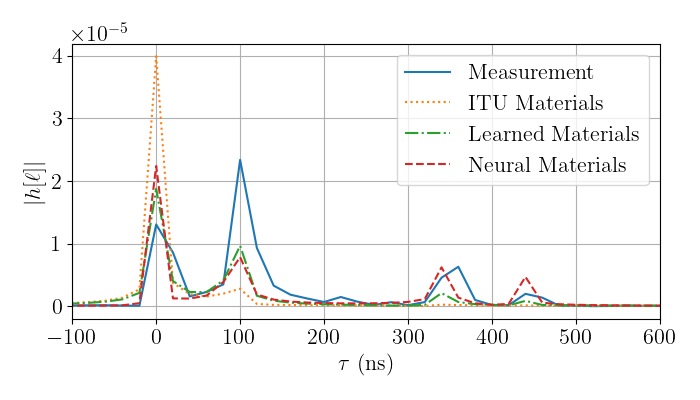

In [9]:
plot_cir("cir-1.pdf", True)

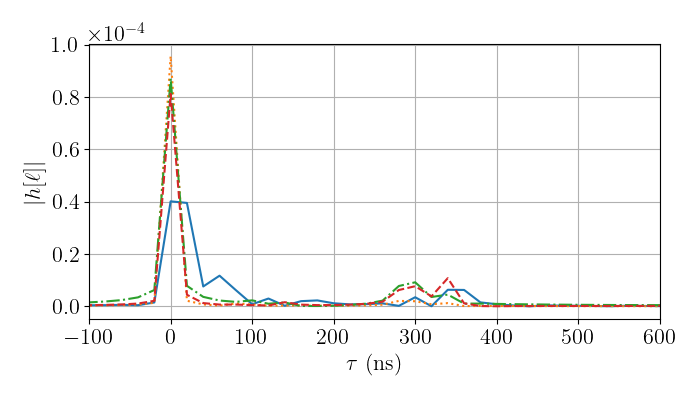

In [10]:
plot_cir("cir-2.pdf", False)

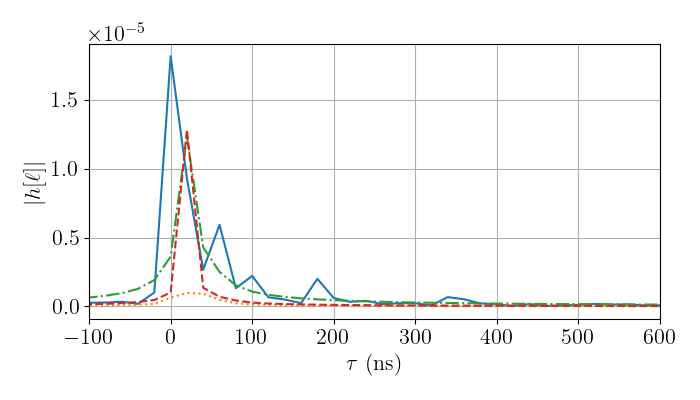

In [11]:
plot_cir("cir-3.pdf", False)

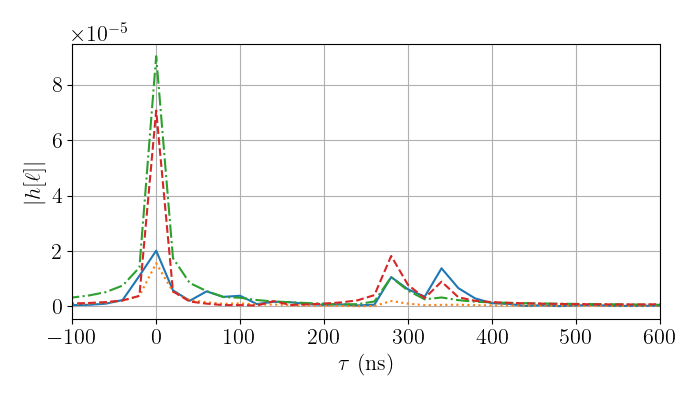

In [12]:
plot_cir("cir-4.pdf", False)